In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import networkx as nx

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>Understanding the data</h3>

The date range is from 1 January 2015 to 30 November 2017 and then 1 December 2017 to 31 December 2019.


Tweets before the scandal:

In [94]:
before = pd.read_csv('/content/drive/MyDrive/before.csv')
after = pd.read_csv('/content/drive/MyDrive/after.csv')
before.head()

,handle,name,content,replies,retweets,favorite,unix_timestamp,date,url,search_url,hashtags
0,@steinhoff_s,Spencer,i HATE west virginia basketball.. c'mon you're...,0,3,6,1484101185000,11 Jan 2017,https://twitter.com/steinhoff_s/status/8190058...,https://twitter.com/search?f=live&q=(%22steinh...,NaN
1,@aaron_steinhoff,Aaron Steinhoff,Anybody want to watch cars 3 in 3D with me on ...,0,0,10,1496448085000,03 Jun 2017,https://twitter.com/aaron_steinhoff/status/870...,https://twitter.com/search?f=live&q=(%22steinh...,NaN
2,@loggerbaseball,Lincoln Land Baseball,Loggers win 2nd game 5-3..@devin10smith picks ...,0,0,8,1492212224000,14 Apr 2017,https://twitter.com/loggerbaseball/status/8530...,https://twitter.com/search?f=live&q=(%22steinh...,NaN
3,@Steinhoff_2,Matt Steinhoff 💰♊,GMGB & Lud foe taking over 🤐,0,3,4,1484839091000,19 Jan 2017,https://twitter.com/Steinhoff_2/status/8221008...,https://twitter.com/search?f=live&q=(%22steinh...,NaN
4,@Steinhoff_2,Matt Steinhoff 💰♊,Just tryna find the right girl to grow with an...,0,1,4,1485052798000,22 Jan 2017,https://twitter.com/Steinhoff_2/status/8229972...,https://twitter.com/search?f=live&q=(%22steinh...,NaN


In [95]:
before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   handle          525 non-null    object
 1   name            525 non-null    object
 2   content         525 non-null    object
 3   replies         525 non-null    int64 
 4   retweets        525 non-null    int64 
 5   favorite        525 non-null    int64 
 6   unix_timestamp  525 non-null    int64 
 7   date            525 non-null    object
 8   url             525 non-null    object
 9   search_url      525 non-null    object
 10  hashtags        73 non-null     object
dtypes: int64(4), object(7)
memory usage: 45.2+ KB


In [96]:
before.duplicated().value_counts()

False    525
dtype: int64

In [97]:
#some of the most liked tweets:
bf_sorted = before.sort_values('favorite')
bf_sorted['content'].head(20)

464    Breakout #3 Write On - Steps for Writing - Sta...
311    most oversold REI BATS Pioneer NPN Aspen Stein...
68     South Africa #retail conglomerate Steinhoff is...
427    #VAM23 should be your go-to conference for the...
500               I need new music, somebody put me on 😂
73     #AspireToLeadMN Leadership starts w me every day.
523                   i was blessed with the greatest ❣️
316    Seeing so many takeaways I can incorporate int...
386                                      -5 @steinhoff_s
512                     The Hobbit is such a great movie
346    Looking for some suggestions on engaging liter...
446    Acquired 500 #shares today of Steinhoff Intern...
519    How do fish in the ocean hydrate?They can't dr...
417                                        I love Ohio 😂
419        Need new people to talk to, somebody slide in
301    Also getting to see @ColtGallaway and @steinho...
432                    Happy birthday!! 🎉🎉 @steinhoff_15
408    ON AIR: @Andile_Khumalo 

A few of these are actually about steinhoff.


Tweets after the scandal:

In [98]:
after.head()

,handle,name,content,replies,retweets,favorite,unix_timestamp,date,url,search_url,hashtags
0,@jack_steinhoff,Jack,"People always asking where’s my Juul, not how’...",2,1,9,1569688761000,28 Sep 2019,https://twitter.com/jack_steinhoff/status/1177...,https://twitter.com/search?q=(%22steinhoff%22)...,NaN
1,@FrenchLynch,FrenchLynch,ShowroomPrivé ou l'histoire de la patate chaud...,1,1,4,1542707555000,20 Nov 2018,https://twitter.com/FrenchLynch/status/1064818...,https://twitter.com/search?q=(%22steinhoff%22)...,NaN
2,@SayEntrepreneur,Entrepreneur Zone,The Government Employees Pension Fund (GEPF) h...,49,529,416,1543855237000,03 Dec 2018,https://twitter.com/SayEntrepreneur/status/106...,https://twitter.com/search?q=(%22steinhoff%22)...,NaN
3,@GwenNgwenya,Gwen Ngwenya,This country is so race mad. The EFF and the A...,88,433,1294,1540306242000,23 Oct 2018,https://twitter.com/GwenNgwenya/status/1054746...,https://twitter.com/search?q=(%22steinhoff%22)...,NaN
4,@HeidiGiokos,Heidi Giokos,I have literally been monitoring and watching ...,4,14,14,1557241064000,07 May 2019,https://twitter.com/HeidiGiokos/status/1125776...,https://twitter.com/search?q=(%22steinhoff%22)...,Steinhoff | Steinhoff | eNCA


In [99]:
after.duplicated().value_counts()

False    580
dtype: int64

In [100]:
after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   handle          580 non-null    object
 1   name            580 non-null    object
 2   content         580 non-null    object
 3   replies         580 non-null    int64 
 4   retweets        580 non-null    int64 
 5   favorite        580 non-null    int64 
 6   unix_timestamp  580 non-null    int64 
 7   date            580 non-null    object
 8   url             580 non-null    object
 9   search_url      580 non-null    object
 10  hashtags        231 non-null    object
dtypes: int64(4), object(7)
memory usage: 50.0+ KB


In [101]:
#some of the most liked tweets:
af_sorted = after.sort_values('favorite')
af_sorted['content'].head(20)

457    Looking for something unique to add to your ho...
232    Have an interview coming up? Visit our website...
569    Looking for the perfect gift? Create it with B...
333    Student activism is on the rise! Hear from @ma...
184    Take to first step to bring your yurt to life ...
282    Inspire winning in your workspace. This canvas...
363    Think you missed out on the cryptocurrency boo...
77     If you take a look at Enron, Steinhoff, Lehman...
450    Man, Black people honestly just can't accept t...
15     .@gradidgec @iamkoshiek who is getting aggress...
265    8:30 pm Steinhoff Park Wallaceburg. Watch your...
171    Why are these raids colour blind? Marcus Joost...
426    後方攻撃は自殺行為に等しい。敵爆撃機との相対速度が小さいから敵の火網の格好の餌食だ。前方攻撃...
378    The FTSE/JSE Africa All Share Index rose 0.5% ...
572    Just hit a sweet collateral in MW2. Really bri...
357    Były minister gospodarki, ekspert górniczy Jan...
147    Markus Jooste#Steinhoff- you got paid the big ...
22     Almost the entire @MYANC

A good portion are about Steinhoff.

This data is mixed, its content includes the keyword, however, the scraped tweets also include users whose username and display name has the keyword in them.

In [102]:
before['handle'].value_counts()

@Steinhoff_2       117
@steinhoff_s        74
@steinhoff_15       48
@Richards_Karin     32
@Ben_Steinhoff      26
                  ... 
@Assupol7s           1
@marknarramore1      1
@lthsportersAD       1
@havrecaumartin      1
@iswiegers           1
Name: handle, Length: 131, dtype: int64

In [103]:
after['handle'].value_counts()

@steinhoff_s        52
@TheoTjbbotha       10
@Sentletse           9
@AnnikaLarsen1       9
@ThompsonWarren8     8
                    ..
@anynines            1
@mbindwane           1
@CharlesWiniecki     1
@ZeldalaGrangeSA     1
@BongaDlulane        1
Name: handle, Length: 338, dtype: int64

It is clear that a good portition of the scraped tweets do include some level of irrelevant data.

<Axes: >

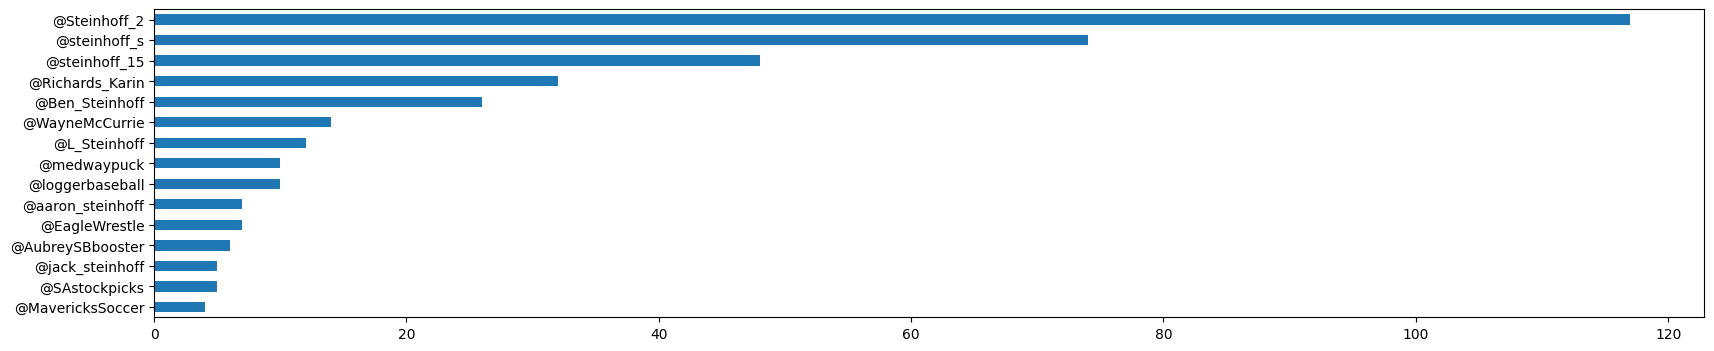

In [104]:
plt.figure(figsize=(20,4))
before['handle'].value_counts()[:15].sort_values(ascending=True).plot(kind='barh')

It is quite clear already that before the scandal, many tweets and tweeters were from people completely dissociated from finance.

<Axes: >

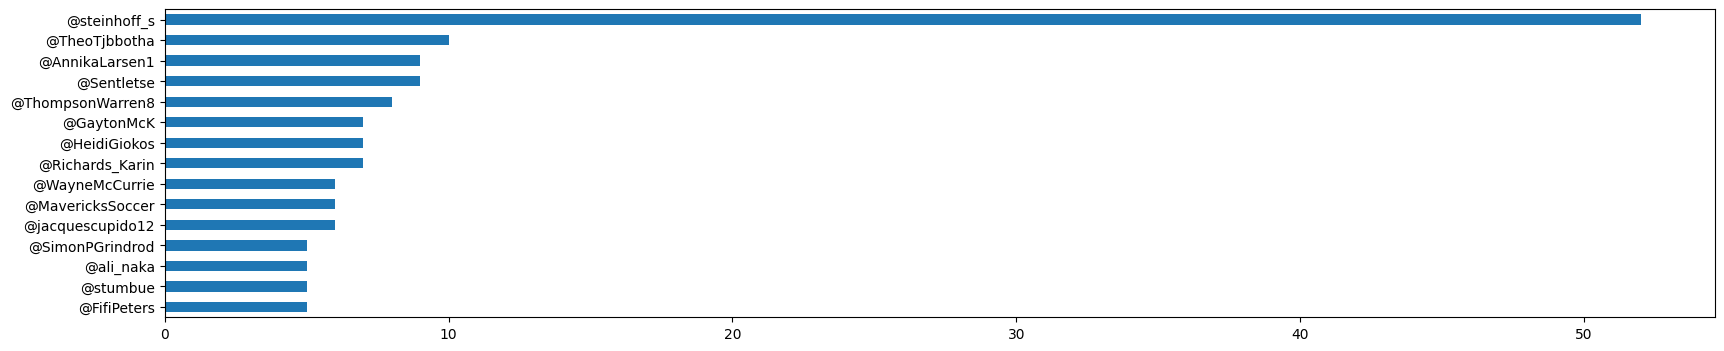

In [105]:
plt.figure(figsize=(20,4))
after['handle'].value_counts()[:15].sort_values(ascending=True).plot(kind='barh')

It is clear now that most of the top tweeters are people related to finance and news. This is quite a difference to before the scandal.

Preprocessed data.

In [106]:
bef_tw = pd.read_excel('/content/drive/MyDrive/before.xlsx')
af_tw = pd.read_excel('/content/drive/MyDrive/after.xlsx')

In [107]:
bef_tw.head()

,content
0,Hou vas jou matras $Steinhoff is weer los!
1,Goldman downgrade Steinhoff to a sell .
2,Steinhoff now up +6% despite stronger ZAR - wo...
3,Steinhoff must learn to disclose all market se...
4,Steinhoff: My German ain't good but JPMorgan m...


In [108]:
bef_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [109]:
af_tw.head()

,content
0,ShowroomPrivé or the history of the hot potato...
1,The Government Employees Pension Fund (GEPF) h...
2,This country is so race mad. The EFF and the A...
3,I have literally been monitoring and watching ...
4,Do you know anyone who has been arrested since...


In [110]:
af_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  444 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB


<h3>Annotation</h3>

Tweets before the scandal:

In [111]:
text_list_before = bef_tw['content'].tolist()

train_before, test_before = train_test_split(text_list_before, test_size=0.2, random_state=42)

train_before_labels = []
for text in train_before:
    label = input(f"Sentiment:\n\n{text}\n\nEnter 1 for positive, 2 for negative 0 for neutral: ")
    train_before_labels.append(int(label))

In [112]:
test_before_labels = []
for text in test_before:
    label = input(f"Sentiment:\n\n{text}\n\nEnter 0 for neutral 1 for positive, 2 for negative: ")
    test_before_labels.append(int(label))

In [113]:
test_before_labels = pd.Series(test_before_labels)
test_before_labels.to_csv('test_before_labels.csv',index=True)

Tweets after the scandal:

In [114]:
text_list_after = af_tw['content'].tolist()

train_after, test_after = train_test_split(text_list_after, test_size=0.3, random_state=42)


train_after_labels = []
for text in train_after:
    label = input(f"Sentiment:\n\n{text}\n\nEnter 0 for neutral, 1 for positive & 2 for negative: ")
    train_after_labels.append(int(label))

In [115]:
test_after_labels = []
for text in test_after:
    label = input(f"Sentiment:\n\n{text}\n\nEnter 0 for neutral 1 for positive, 2 for negative: ")
    test_after_labels.append(int(label))

In [116]:
train_after_labels = pd.Series(train_after_labels)
train_after_labels.to_csv('after_sentiments.csv',index=True)

<h3>Preprocessing</h3>

In [117]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [118]:
def preprocess_texts(texts):
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    preprocessed_texts = []
    
    for text in texts:
        
        text = text.lower()

        tokens = word_tokenize(text)

        filtered_tokens = [token for token in tokens if token not in stop_words]

        lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

        preprocessed_text = ' '.join(lemma_tokens)

        preprocessed_texts.append(preprocessed_text)

    return preprocessed_texts


In [119]:
train_before_clean = preprocess_texts(train_before)
test_before_clean = preprocess_texts(test_before)

In [120]:
train_after_clean = preprocess_texts(train_after)
test_after_clean = preprocess_texts(test_after)

<h3>Feature Extraction</h3>

In [121]:
tfidf_before = TfidfVectorizer()
tfidf_after = TfidfVectorizer()

vector_train_before = tfidf_before.fit_transform(train_before_clean)
vector_test_before = tfidf_before.transform(test_before_clean)


vector_train_after = tfidf_after.fit_transform(train_after_clean)
vector_test_after = tfidf_after.transform(test_after_clean)

In [122]:
tfidf_before.get_feature_names_out()[:20]

array(['00', '011', '10', '10h00', '10x', '12', '13', '14th', '15', '16',
       '18', '2016', '2017', '20xp', '21', '24', '27', '280', '30pm',
       '32'], dtype=object)

In [123]:
tfidf_after.get_feature_names_out()[-20:]

array(['wrongdoing', 'wrote', 'wse', 'wtf', 'year', 'yes', 'yesterday',
       'yet', 'yey', 'yfm', 'young', 'yunus', 'zach', 'zandile',
       'zandilegumede', 'zero', 'zondo', 'zuma', 'zumatrial', 'zyl'],
      dtype=object)

In [124]:
train_labels_before = pd.read_csv('/content/drive/MyDrive/before_sentiments.csv')
test_labels_before = pd.read_csv('/content/drive/MyDrive/test_before_labels.csv')

train_labels_after = pd.read_csv('/content/drive/MyDrive/after_sentiments.csv')
test_labels_after = pd.read_csv('/content/drive/MyDrive/test_after_sentiments.csv')

<h3>Visualisation</h3>

<h4>WordCloud</h4>

In [125]:
np.unique(tfidf_before.get_feature_names_out()[:50])

array(['00', '011', '10', '10h00', '10x', '12', '13', '14th', '15', '16',
       '18', '2016', '2017', '20xp', '21', '24', '27', '280', '30pm',
       '32', '34', '37', '3733', '40', '42', '50', '500', '51', '52',
       '55', '60', '70', '75', '76', '80', '90', 'a14xb9', 'abinbev',
       'accounting', 'acquire', 'acquired', 'acquisition', 'admire',
       'africa', 'african', 'agreement', 'air', 'ajeevalentine',
       'allowed', 'allshare'], dtype=object)

In [126]:
vocab_before = tfidf_before.get_feature_names_out()
vocab_after = tfidf_after.get_feature_names_out()

matrix_train_before = vector_train_before.toarray()
matrix_test_before = vector_test_before.toarray()

matrix_train_after = vector_train_after.toarray()
matrix_test_after = vector_test_after.toarray()

vector_train_before = sp.sparse.csr_matrix(matrix_train_before)
vector_test_before = sp.sparse.csr_matrix(matrix_test_before)

vector_train_after = sp.sparse.csr_matrix(matrix_train_after)
vector_test_after = sp.sparse.csr_matrix(matrix_test_after)


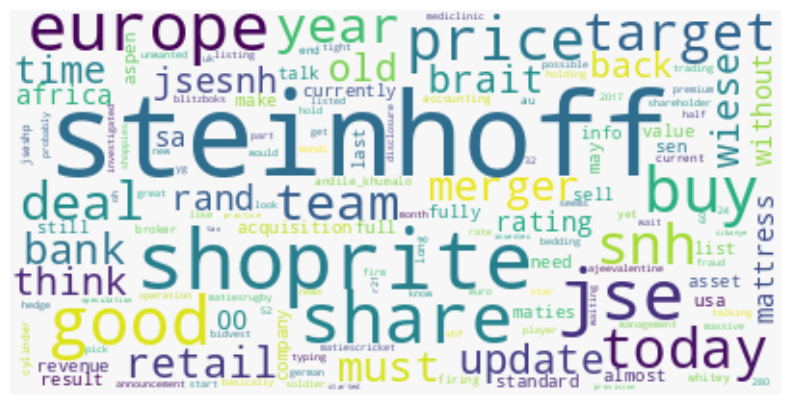

In [127]:
wordcloud_before = WordCloud(background_color="#f7f7f7").generate_from_frequencies(word_freq_before)
wordcloud_after = WordCloud(background_color="#f7f7f7").generate_from_frequencies(word_freq_after)

plt.figure(figsize=(20,5))
plt.imshow(wordcloud_before, interpolation="bilinear")
plt.axis("off")
plt.show()

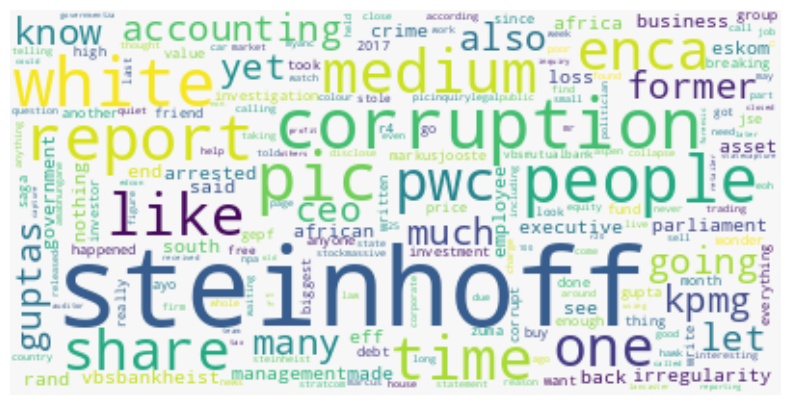

In [128]:
plt.figure(figsize=(20,5))
plt.imshow(wordcloud_after, interpolation="bilinear")
plt.axis("off")
plt.show()